In [9]:
import chainer
from chainer import training, iterators, optimizers, serializers, Chain
import chainer.functions as F
import chainer.links as L
 
from chainer.training import extensions
from chainer.datasets import tuple_dataset
import numpy as np

In [10]:
def data_read( file_name, key_data, is_one_hot ):
    teachers = np.array([] )
    answers =  np.array([] )

    f = open( file_name, mode = "r" )

    f_string = f.readlines()

    day_data = np.array([] )
    tmp_data = np.array([] )
    for i in range( 0, len( f_string ) ):
        
        day_data = np.append( day_data, float(f_string[i].replace( "\n", "" )))
        
        # 一日のデータを格納する
        if( (i+1)%6 == 0 and i != 0 ):
            # 引数を軸にデータを教師データと正解ラベルに振り分ける
            if( (i+1)//6%key_data == 0):
                # 正解ラベルは終値
                teachers = np.append( teachers, tmp_data)
                # 正解ラベルをone hotで表現する場合
                if( is_one_hot ):
                    answers = np.append( answers, tmp_data[6 * (key_data - 1) - 3] > day_data[3])
                else:
                    answers = np.append( answers, day_data[3] )
                tmp_data = np.array([] )
            else:
                tmp_data = np.append( tmp_data, day_data)
                #teachers = np.append( teachers, day_data )
            day_data = np.array([] )
            
    f.close()

    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.float32 )

    #teachers = np.reshape( teachers, ( int( len( teachers ) / 6 ), 6 ) )
    #answers = np.reshape( answers, ( len( answers ) , 1 ) )

    return teachers, answers


In [11]:
def take_data(year, key_day, is_one_hot):
    file = open('nikkei.txt')
    stock_numbers = file.readlines()
    file.close()
    
    teachers = np.array([] )
    answers =  np.array([] )
    
    for number in stock_numbers:
        number = number.rstrip('\n')
        tmp_teacher, tmp_answer = data_read('./data/{}_{}.txt'.format(number, year), key_day, is_one_hot)
        teachers = np.append( teachers, tmp_teacher)
        answers = np.append( answers, tmp_answer)
        
    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.float32 )

    teachers = np.reshape( teachers, ( int( len( teachers ) / (6 * (key_day-1) ) ), 6 * (key_day-1) ) )
    answers = np.reshape( answers, ( len( answers ) , 1 ) )
    answers = answers.flat[:]

    return teachers, answers

In [15]:
#ニューラルネットワークの構築。
class MyChain(Chain):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(MyChain, self).__init__(
        l1=L.Linear(n_input, n_hidden[0]),
        l2=L.Linear(n_hidden[0], n_hidden[1]),
        #l3=L.Linear(n_hidden[1], n_output),
        l3=L.Linear(n_hidden[1], n_hidden[2]),
        l4=L.Linear(n_hidden[2], n_output),
        #l4=L.Linear(n_hidden[2], n_hidden[3]),
        #l5=L.Linear(n_hidden[3], n_hidden[4]),
        #l6=L.Linear(n_hidden[4], n_hidden[5]),
        #l7=L.Linear(n_hidden[5], n_hidden[5]),
        #l8=L.Linear(n_hidden[5], n_output),
    )
 
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        #o = self.l3(h2)
        h3 = F.relu(self.l3(h2))
        o = self.l4(h3)
        #o = F.relu(self.l4(h3))
        #h4 = F.relu(self.l4(h3))
        #h5 = F.relu(self.l5(h4))
        #h6 = F.relu(self.l6(h5))
        #h7 = F.relu(self.l7(h6))
        #o = self.l8(h7)
        return o

    

In [16]:
# 何日間のデータで学習させるか
key_data = 6

teachers, answers = take_data(2018, key_data, True)
#学習、検証データの割合(単位：割)
trainSt = 0 #学習用データの開始位置 0割目から〜
trainPro = 8 #学習用データの終了位置　8割目まで
testPro = 10 #検証用データの終了位置 8割目から10割目まで

#総データの長さ
N = len(teachers)

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}

#学習用データと検証用データに分ける
train_teach= teachers[:N*trainPro//10]
test_teach = teachers[N*trainPro//10:]

train_ans= answers[:N*trainPro//10].astype(np.int32)
test_ans = answers[N*trainPro//10:].astype(np.int32)

#モデルを使う準備。オブジェクトを生成
n_input = (key_data-1)*6
#n_hidden = [(key_data-1)*6, (key_data-1)*4,(key_data-1)*4, (key_data-1)*3, (key_data-1)*2, key_data]
n_hidden = [ (key_data-1)*6, (key_data-1)*3, key_data-1]
#n_hidden = [ (key_data-1)*3, key_data-1]
n_output = 2
model = MyChain(n_input, n_hidden, n_output)

# 最適化を行う
optimizer = chainer.optimizers.Adam()
#optimizer = chainer.optimizers.SGD(lr=0.01)
optimizer.setup(model)

n_epoch = 20
n_batchsize = 16

# 各バッチ毎の目的関数の出力と分類精度の保存用
loss_list = []
accuracy_list = []

print(teachers.shape)
print(answers.shape)

(8920, 30)
(8920,)


In [17]:
from chainer.dataset import concat_examples
from chainer import Variable
for epoch in range(n_epoch):
        
    ite  = chainer.iterators.SerialIterator(train_teach, batch_size=n_batchsize, 
                                            repeat=False, shuffle=True)
    for i in range(0, train_teach.shape[0],n_batchsize):
         
        # 予測値を出力
        #train_batch = ite.next()
        train_batch = train_teach[i:i+n_batchsize-1]
        train_ans_batch = train_ans[i:i+n_batchsize-1]
        #train_batch = concat_examples(train_batch)
        #train_ans_batch = concat_examples(train_ans_batch)
        y_train_batch = model(train_batch)
        
        # 目的関数を適用し、分類精度を計算
        #loss_train_batch = F.mean_squared_error(y_train_batch, train_ans_batch)
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, train_ans_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, train_ans_batch.flatten().astype(np.int32))

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)
    
        # 勾配のリセットと勾配の計算
        model.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update() 
        
    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        test_ans_y = model(test_teach)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(test_ans_y, test_ans)
    accuracy_val = F.accuracy(test_ans_y, test_ans.flatten().astype(np.int32))

    # 結果の表示
    print('epoch: {},loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0,loss (train): 539.1160, loss (valid): 1.3574
epoch: 1,loss (train): 274.2882, loss (valid): 0.6969
epoch: 2,loss (train): 183.2579, loss (valid): 0.6972
epoch: 3,loss (train): 137.6156, loss (valid): 0.6973
epoch: 4,loss (train): 110.2302, loss (valid): 0.6973
epoch: 5,loss (train): 91.9733, loss (valid): 0.6973
epoch: 6,loss (train): 78.9326, loss (valid): 0.6973
epoch: 7,loss (train): 69.1521, loss (valid): 0.6972
epoch: 8,loss (train): 61.5450, loss (valid): 0.6972
epoch: 9,loss (train): 55.4594, loss (valid): 0.6972
epoch: 10,loss (train): 50.4802, loss (valid): 0.6972
epoch: 11,loss (train): 46.3309, loss (valid): 0.6972
epoch: 12,loss (train): 42.8200, loss (valid): 0.6972
epoch: 13,loss (train): 39.8106, loss (valid): 0.6972
epoch: 14,loss (train): 37.2024, loss (valid): 0.6972
epoch: 15,loss (train): 34.9203, loss (valid): 0.6972
epoch: 16,loss (train): 32.9067, loss (valid): 0.6972
epoch: 17,loss (train): 31.1168, loss (valid): 0.6972
epoch: 18,loss (train): 29.5153, 

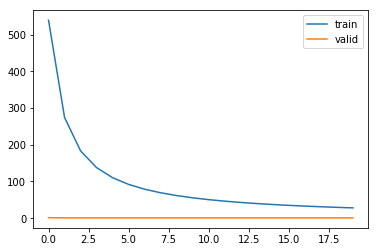

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

#目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

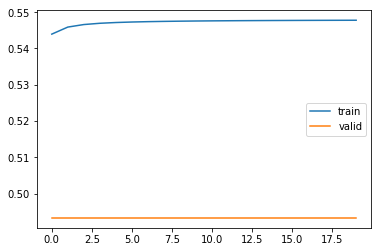

In [19]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示